In [ ]:
!pip install pycocotools

In [ ]:
!pip install torchmetrics

In [31]:
import torch as tc
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision as tv
from torchvision import transforms, models

from tqdm import tqdm

import matplotlib.pyplot as plt

from torchmetrics.detection import MeanAveragePrecision

import os

import numpy as np

from PIL import Image

import pycocotools.coco as coco

import re

import random
import cv2
from google.colab.patches import cv2_imshow

In [4]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
!unzip PennFudanPed.zip

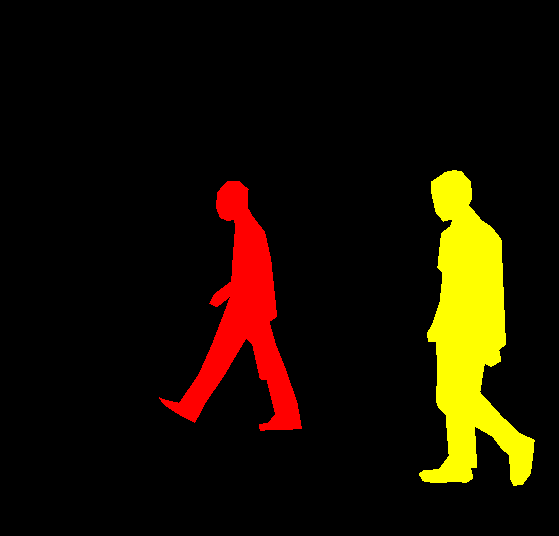

In [7]:
mask = Image.open('/content/PennFudanPed/PedMasks/FudanPed00001_mask.png').convert('P')
mask.putpalette([0, 0, 0,
                 255, 0, 0,
                 255, 255, 0,
                 255, 153, 0])
mask

In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [9]:
import utils
import transforms as T

In [10]:
class PennFudanPen(Dataset):

  def __init__(self, root, transform = None):
    super(PennFudanPen, self).__init__()
    self.root = root
    self.ann  = os.listdir(self.root)
    self.transform = transform

  def __getitem__(self, index):
    ann_address = self.root + self.ann[index]
    with open(ann_address, "r") as file:
          content = file.read()

    content       = content.splitlines()
    image_address = content[1].split(':')[1].split('"')[1]
    mask_address  = content[11].split(':')[1].split('"')[1]
    n_object      = int(content[4].split(':')[1].split('{')[0])
    boxes = []
    for i in range(n_object):
        box = []
        numbers = re.findall(r'\d+', content[10 + i * 5].split(':')[1])
        box.append(int(numbers[0]))
        box.append(int(numbers[1]))
        box.append(int(numbers[2]))
        box.append(int(numbers[3]))
        boxes.append(box)
    boxes   = tc.tensor(boxes, dtype = tc.float32)
    labels  = tc.ones(boxes.shape[0], dtype = tc.int64)
    targets = {}
    targets['boxes']  = boxes
    targets['labels'] = labels
    image        = Image.open(image_address)
    image_tensor = transforms.functional.to_tensor(image)
    mask         = Image.open(mask_address)
    mask         = np.array(mask)
    obj_ids      = np.unique(mask)[1:]
    masks        = mask == obj_ids[:, None, None]
    masks        = tc.as_tensor(masks, dtype = tc.uint8)

    targets['masks'] = masks

    if self.transform:
      image_tensor, targets = self.transform(image_tensor, targets)

    return image_tensor, targets

  def __len__(self):
    return len(self.ann)

In [11]:
dataset = PennFudanPen('/content/PennFudanPed/Annotation/')

In [12]:
len(dataset)

170

In [13]:
train_dataset, valid_dataset = random_split(dataset, [150, len(dataset) - 150])

In [14]:
len(train_dataset), len(valid_dataset)

(150, 20)

In [15]:
train_loader = DataLoader(dataset, batch_size = 2, shuffle = True, num_workers = 4, collate_fn = utils.collate_fn)
valid_loader = DataLoader(dataset, batch_size = 2, shuffle = False, num_workers = 4, collate_fn = utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
dataset[141]

(tensor([[[0.0627, 0.0667, 0.0706,  ..., 0.7961, 0.7804, 0.7608],
          [0.0745, 0.0745, 0.0745,  ..., 0.7216, 0.7137, 0.6980],
          [0.0667, 0.0706, 0.0706,  ..., 0.6627, 0.6510, 0.6353],
          ...,
          [0.5059, 0.5059, 0.5098,  ..., 0.5529, 0.5647, 0.5725],
          [0.5176, 0.5176, 0.5216,  ..., 0.5647, 0.5686, 0.5725],
          [0.5176, 0.5216, 0.5255,  ..., 0.5882, 0.5804, 0.5765]],
 
         [[0.0667, 0.0706, 0.0745,  ..., 0.7529, 0.7373, 0.7176],
          [0.0784, 0.0784, 0.0784,  ..., 0.6784, 0.6706, 0.6549],
          [0.0706, 0.0745, 0.0745,  ..., 0.6196, 0.6078, 0.5922],
          ...,
          [0.5137, 0.5137, 0.5176,  ..., 0.5608, 0.5725, 0.5804],
          [0.5255, 0.5255, 0.5294,  ..., 0.5725, 0.5765, 0.5804],
          [0.5255, 0.5294, 0.5333,  ..., 0.5961, 0.5882, 0.5843]],
 
         [[0.0824, 0.0784, 0.0824,  ..., 0.7294, 0.7137, 0.6941],
          [0.0941, 0.0863, 0.0863,  ..., 0.6549, 0.6471, 0.6314],
          [0.0863, 0.0824, 0.0824,  ...,

In [17]:
def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))

  return T.Compose(transforms)

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
def train_one_epoch(model, train_loader, loss_func, optimizer, shedular, epoch):
    model.train()

    train_loss=AverageMeter()

    with tqdm(train_loader, unit='batch') as tepoch:
        for idx, (images, targets) in enumerate(tepoch):
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            optimizer.zero_grad()

            images  = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            loss_dict = model(images, targets)
            loss      = sum(error for error in loss_dict.values())

            loss.backward()
            optimizer.step()
            shedular.step()

            train_loss.update(loss.item())


            tepoch.set_postfix(loss=train_loss.avg)

    return model, train_loss.avg

In [20]:
def validation(model, valid_loaedr, loss_func, device):
    model.eval()
    model = model.to(device)

    map = MeanAveragePrecision('xyxy')

    for batch in valid_loaedr:

        images  = [image.to(device) for image in batch[0]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch[1]]

        with tc.no_grad():
          pred = model(images)


        map.update(pred, targets)

    print('========================================================================================')
    print(f"|| mAP               = {map.compute()['map']:0.2}      ||    mAP|50     = {map.compute()['map_50']:0.2}    ||   mAP|75    ={ map.compute()['map_75']:0.2}  ||")
    print('========================================================================================')
    print(f"|| mAP|small         = {map.compute()['map_small']:0.2}      ||    mAP|medium = {map.compute()['map_medium']:0.2}    ||   mAP|large = {map.compute()['map_large']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAR|1             = {map.compute()['mar_1']:0.2}      ||    mAR|10     = {map.compute()['mar_10']:0.2}    ||   mAR|100   = {map.compute()['mar_100']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAR|small         = {map.compute()['mar_small']:0.2}      ||    mAR|medium = {map.compute()['mar_medium']:0.2}    ||   mAR|large = {map.compute()['mar_large']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAP|per_class     = {map.compute()['map_per_class']:0.2}      ||                         ||                    ||")
    print('========================================================================================')
    print(f"|| mAR|100_per_class = {map.compute()['mar_100_per_class']:0.2}      ||                         ||                    ||")
    print('========================================================================================')


    return map

In [26]:
model = models.detection.maskrcnn_resnet50_fpn(True)

In [27]:
model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(256, 256, 2)
model.roi_heads.box_predictor  = models.detection.faster_rcnn.FastRCNNPredictor(1024, 2)

In [28]:
model = model.to(device)

In [29]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, 2000, 1e-7)

In [30]:
start, end = 0, 15
for i in range(start, end):

  model, train_loss = train_one_epoch(model, train_loader, None,  optimizer, shedular, i)
  vali_map          = validation(model, valid_loader, None, device)

Epoch=0: 100%|██████████| 85/85 [00:49<00:00,  1.73batch/s, loss=0.618]


|| mAP               = 0.67      ||    mAP|50     = 0.98    ||   mAP|75    =0.83  ||
|| mAP|small         = 0.33      ||    mAP|medium = 0.52    ||   mAP|large = 0.68 ||
|| mAR|1             = 0.3      ||    mAR|10     = 0.74    ||   mAR|100   = 0.74 ||
|| mAR|small         = 0.58      ||    mAR|medium = 0.77    ||   mAR|large = 0.74 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=1: 100%|██████████| 85/85 [00:50<00:00,  1.68batch/s, loss=0.288]


|| mAP               = 0.82      ||    mAP|50     = 0.99    ||   mAP|75    =0.96  ||
|| mAP|small         = 0.36      ||    mAP|medium = 0.64    ||   mAP|large = 0.84 ||
|| mAR|1             = 0.36      ||    mAR|10     = 0.87    ||   mAR|100   = 0.87 ||
|| mAR|small         = 0.62      ||    mAR|medium = 0.83    ||   mAR|large = 0.87 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=2: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.241]


|| mAP               = 0.84      ||    mAP|50     = 0.99    ||   mAP|75    =0.97  ||
|| mAP|small         = 0.49      ||    mAP|medium = 0.69    ||   mAP|large = 0.85 ||
|| mAR|1             = 0.36      ||    mAR|10     = 0.88    ||   mAR|100   = 0.88 ||
|| mAR|small         = 0.64      ||    mAR|medium = 0.82    ||   mAR|large = 0.89 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=3: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.215]


|| mAP               = 0.89      ||    mAP|50     = 0.99    ||   mAP|75    =0.98  ||
|| mAP|small         = 0.53      ||    mAP|medium = 0.78    ||   mAP|large = 0.9 ||
|| mAR|1             = 0.38      ||    mAR|10     = 0.92    ||   mAR|100   = 0.92 ||
|| mAR|small         = 0.68      ||    mAR|medium = 0.88    ||   mAR|large = 0.92 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=4: 100%|██████████| 85/85 [00:50<00:00,  1.68batch/s, loss=0.198]


|| mAP               = 0.9      ||    mAP|50     = 1.0    ||   mAP|75    =0.98  ||
|| mAP|small         = 0.53      ||    mAP|medium = 0.8    ||   mAP|large = 0.91 ||
|| mAR|1             = 0.38      ||    mAR|10     = 0.93    ||   mAR|100   = 0.93 ||
|| mAR|small         = 0.68      ||    mAR|medium = 0.89    ||   mAR|large = 0.93 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=5: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.19]


|| mAP               = 0.9      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.58      ||    mAP|medium = 0.82    ||   mAP|large = 0.9 ||
|| mAR|1             = 0.38      ||    mAR|10     = 0.93    ||   mAR|100   = 0.93 ||
|| mAR|small         = 0.72      ||    mAR|medium = 0.89    ||   mAR|large = 0.93 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=6: 100%|██████████| 85/85 [00:50<00:00,  1.68batch/s, loss=0.179]


|| mAP               = 0.92      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.65      ||    mAP|medium = 0.85    ||   mAP|large = 0.93 ||
|| mAR|1             = 0.39      ||    mAR|10     = 0.95    ||   mAR|100   = 0.95 ||
|| mAR|small         = 0.74      ||    mAR|medium = 0.9    ||   mAR|large = 0.95 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=7: 100%|██████████| 85/85 [00:50<00:00,  1.68batch/s, loss=0.17]


|| mAP               = 0.93      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.65      ||    mAP|medium = 0.87    ||   mAP|large = 0.94 ||
|| mAR|1             = 0.39      ||    mAR|10     = 0.95    ||   mAR|100   = 0.95 ||
|| mAR|small         = 0.74      ||    mAR|medium = 0.92    ||   mAR|large = 0.96 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=8: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.167]


|| mAP               = 0.94      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.7      ||    mAP|medium = 0.86    ||   mAP|large = 0.95 ||
|| mAR|1             = 0.39      ||    mAR|10     = 0.96    ||   mAR|100   = 0.96 ||
|| mAR|small         = 0.76      ||    mAR|medium = 0.91    ||   mAR|large = 0.96 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=9: 100%|██████████| 85/85 [00:50<00:00,  1.68batch/s, loss=0.164]


|| mAP               = 0.95      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.71      ||    mAP|medium = 0.89    ||   mAP|large = 0.96 ||
|| mAR|1             = 0.39      ||    mAR|10     = 0.97    ||   mAR|100   = 0.97 ||
|| mAR|small         = 0.76      ||    mAR|medium = 0.94    ||   mAR|large = 0.97 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=10: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.158]


|| mAP               = 0.96      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.73      ||    mAP|medium = 0.92    ||   mAP|large = 0.96 ||
|| mAR|1             = 0.4      ||    mAR|10     = 0.97    ||   mAR|100   = 0.97 ||
|| mAR|small         = 0.78      ||    mAR|medium = 0.95    ||   mAR|large = 0.97 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=11: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.157]


|| mAP               = 0.94      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.77      ||    mAP|medium = 0.9    ||   mAP|large = 0.94 ||
|| mAR|1             = 0.39      ||    mAR|10     = 0.96    ||   mAR|100   = 0.96 ||
|| mAR|small         = 0.8      ||    mAR|medium = 0.94    ||   mAR|large = 0.96 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=12: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.153]


|| mAP               = 0.96      ||    mAP|50     = 1.0    ||   mAP|75    =0.99  ||
|| mAP|small         = 0.75      ||    mAP|medium = 0.92    ||   mAP|large = 0.97 ||
|| mAR|1             = 0.4      ||    mAR|10     = 0.98    ||   mAR|100   = 0.98 ||
|| mAR|small         = 0.78      ||    mAR|medium = 0.96    ||   mAR|large = 0.98 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=13: 100%|██████████| 85/85 [00:50<00:00,  1.68batch/s, loss=0.149]


|| mAP               = 0.96      ||    mAP|50     = 1.0    ||   mAP|75    =1.0  ||
|| mAP|small         = 0.8      ||    mAP|medium = 0.92    ||   mAP|large = 0.96 ||
|| mAR|1             = 0.4      ||    mAR|10     = 0.97    ||   mAR|100   = 0.97 ||
|| mAR|small         = 0.8      ||    mAR|medium = 0.95    ||   mAR|large = 0.98 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=14: 100%|██████████| 85/85 [00:50<00:00,  1.69batch/s, loss=0.149]


|| mAP               = 0.97      ||    mAP|50     = 1.0    ||   mAP|75    =1.0  ||
|| mAP|small         = 0.8      ||    mAP|medium = 0.92    ||   mAP|large = 0.97 ||
|| mAR|1             = 0.4      ||    mAR|10     = 0.98    ||   mAR|100   = 0.98 ||
|| mAR|small         = 0.8      ||    mAR|medium = 0.96    ||   mAR|large = 0.98 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


In [33]:
coco_names = ['__background__','person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','traffic light','fire hydrant','stop sign',
'parking meter','bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase',
'frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket','bottle','wine glass','cup',
'fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant','bed',
'dining table','toilet','tv','laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster','sink',
'refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush']

In [117]:
def get_outputs(image, model, threshold):
  model.eval()
  with tc.no_grad():
    output = model([image])

  scores = list(output[0]['scores'].detach().cpu().numpy())
  thresholded_pred_indices = [scores.index(i) for i in scores if i>threshold]
  thresholded_pred_count   = len(thresholded_pred_indices)
  masks  = (output[0]['masks']>0.5).detach().cpu().numpy()
  masks  = masks[:thresholded_pred_count]
  boxes  = [[int(i[0]), int(i[1]), int(i[2]), int(i[3])] for i in output[0]['boxes'].detach().cpu()]
  boxes  = boxes[:thresholded_pred_count]
  labels = [coco_names[i] for i in output[0]['labels']]

  return masks, boxes, labels

In [165]:
images, targets = next(iter(valid_loader))

In [166]:
images = [image for image in images]

In [47]:
model.eval()
model = model.cpu()

In [167]:
masks, boxes, labels = get_outputs(images[1], model, threshold = 0.90)

In [168]:
image = tc.tensor(images[1], dtype = tc.uint8)
masks = tc.tensor(masks, dtype = tc.bool)

<ipython-input-168-1091f358388f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = tc.tensor(images[1], dtype = tc.uint8)


In [169]:
i = tv.utils.draw_segmentation_masks(image, masks.squeeze(), 1, ['red', 'green', 'blue'])

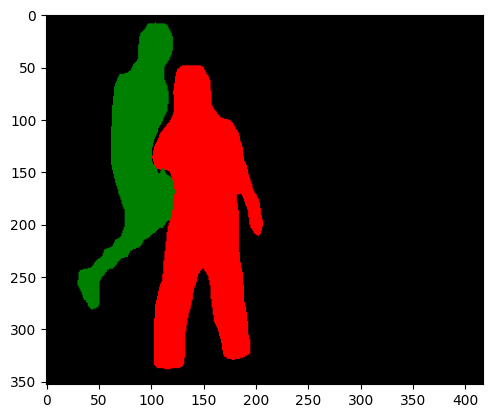

In [170]:
plt.imshow(i.permute(1, 2, 0))

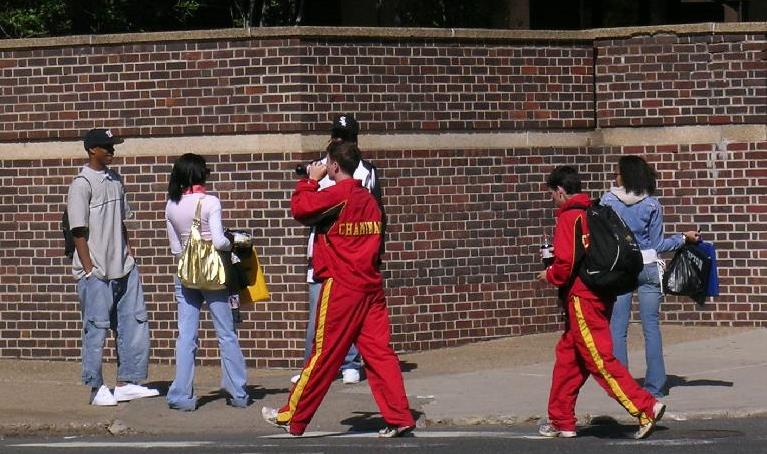

In [185]:
image = Image.open('/content/PennFudanPed/PNGImages/PennPed00005.png')
image

In [186]:
image_tensor = transforms.functional.to_tensor(image)

In [187]:
masks, boxes, labels = get_outputs(image_tensor, model, threshold = 0.80)

In [188]:
image_tensor = tc.tensor(image_tensor, dtype = tc.uint8)
masks = tc.tensor(masks, dtype = tc.bool)

<ipython-input-188-4538b4fd678b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = tc.tensor(image_tensor, dtype = tc.uint8)


In [189]:
seg = tv.utils.draw_segmentation_masks(image_tensor, masks.squeeze(), 1, ['red', 'green', 'blue', 'white', 'yellow'])

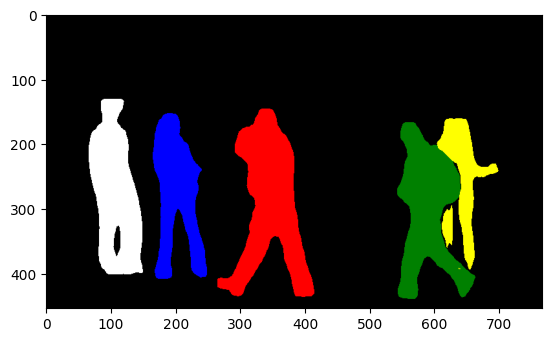

In [190]:
plt.imshow(seg.permute(1, 2, 0))

In [191]:
from matplotlib.patches import Rectangle

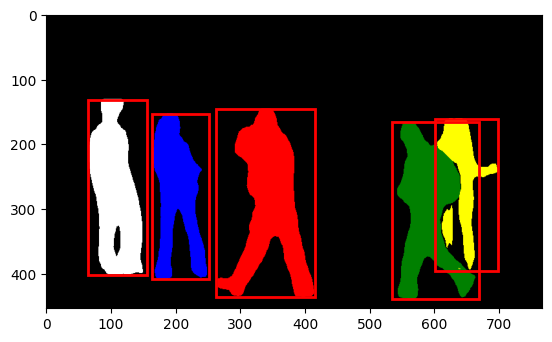

In [192]:
np_arr = seg.permute(1, 2, 0)
plt.imshow(np_arr)

ax = plt.gca()
for box, label in zip(boxes, labels):
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill = False,
                     edgecolor = (1, 0, 0),
                     linewidth = 2)
    ax.add_patch(rect)

plt.show()